先对Train数据集进行训练，选择80%的训练和20%的验证，最后用test数据进行测试，由于数据已经是清洗好的，直接开始导入。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.layers import Layer
import scipy.stats as stats

In [2]:
# 多变量多时间步GRU加注意力预测，其实这里为了代码简明可以直接引用其他文件中定义的模型。

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())

        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [3]:
# 导入数据并删除时间列
file_path = r"D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\step3_data.csv"
data = pd.read_csv(file_path)
df = data.drop(['timestamp'],axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192375 entries, 0 to 192374
Data columns (total 8 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Active_Power                  192375 non-null  float64
 1   Wind_Speed                    192375 non-null  float64
 2   Weather_Temperature_Celsius   192375 non-null  float64
 3   Global_Horizontal_Radiation   192375 non-null  float64
 4   Diffuse_Horizontal_Radiation  192375 non-null  float64
 5   Radiation_Global_Tilted       192375 non-null  float64
 6   Radiation_Diffuse_Tilted      192375 non-null  float64
 7   T_c                           192375 non-null  float64
dtypes: float64(8)
memory usage: 11.7 MB


In [4]:
# 一些参数定义
BATCH_SIZE = 128
EPOCHS = 10
SEQ_LEN = 10
FUTURE_PERIOD_PREDICT = 1
targ_cols = ("Active_Power",)

# 一些函数定义
# 归一化，划分feature target
def preprocess_data(dat, col_names):
    scale = MinMaxScaler().fit(dat)
    proc_dat = scale.transform(dat)

    mask = np.ones(proc_dat.shape[1], dtype=bool)
    dat_cols = list(dat.columns)
    for col_name in col_names:
        mask[dat_cols.index(col_name)] = False

    feats = proc_dat[:, mask]
    targs = proc_dat[:, ~mask]

    return feats, targs


# 把数据切分成80%训练集、20%测试集
def split_data(data, percent_train=0.90):
    num_rows = len(data)
    train_data, test_data = [], []
    for idx, row in enumerate(data):
        if idx < num_rows * percent_train:
            train_data.append(row)
        else:
            test_data.append(row)
    return np.array(train_data), np.array(test_data)


In [5]:
# 处理数据集
data_X, data_y = preprocess_data(df, targ_cols)
all_data = np.concatenate([data_X, data_y], axis=1)
train_, test_ = split_data(all_data)

def timestamp_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data) - FUTURE_PERIOD_PREDICT + 1):
        X.append(data[i - SEQ_LEN:i, :data_X.shape[1]])  # 含左不含右
        Y.append(data[i + (FUTURE_PERIOD_PREDICT - 1), data_X.shape[1]])
    return np.array(X), np.array(Y)

X_train, y_train = timestamp_data(train_)
print('X_train', X_train.shape, 'y_train', y_train.shape)
X_test, y_test = timestamp_data(test_)

print("train shape {0}".format(X_train.shape))
print("test shape {0}".format(X_test.shape))

X_train (173128, 10, 7) y_train (173128,)
train shape (173128, 10, 7)
test shape (19227, 10, 7)


In [6]:
# 构建模型并训练

inp = Input(shape=(SEQ_LEN, data_X.shape[1]))
x = GRU(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
x = Attention(SEQ_LEN)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="relu")(x)

model_lstm_attention = tf.keras.Model(inputs=inp, outputs=x)
model_lstm_attention.compile(loss='mean_squared_error', optimizer='adam')
model_lstm_attention.summary()

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')


model_lstm_attention.fit(X_train, y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_test, y_test))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 7)]              0         []                            
                                                                                                  
 gru (GRU)                   (None, 10, 256)              203520    ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 10, 256)              0         ['gru[0][0]']                 
                                                                                                  
 tf.reshape (TFOpLambda)     (None, 256)                  0         ['dropout[0][0]']             
                                                                                              

601/601 [==============================] - 3s 4ms/step

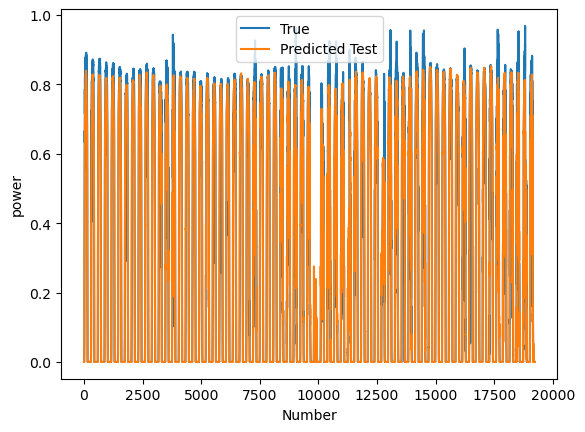

In [7]:
# 绘图看结果
predicted_LSTM_Att = model_lstm_attention.predict(X_test)
True_test = y_test.reshape(-1,1)

plt.plot(True_test, label='True')
plt.plot(predicted_LSTM_Att, label='Predicted Test')
plt.xlabel('Number')
plt.ylabel('power')
plt.legend()
# plt.savefig(
#     "/Users/Arithmetic/pythonProject/lstm+attention/result_pics/lstm+attention_nasdaq_epoch{0}.png".format(EPOCHS))
plt.show()

截取其中的一部分看的更明显

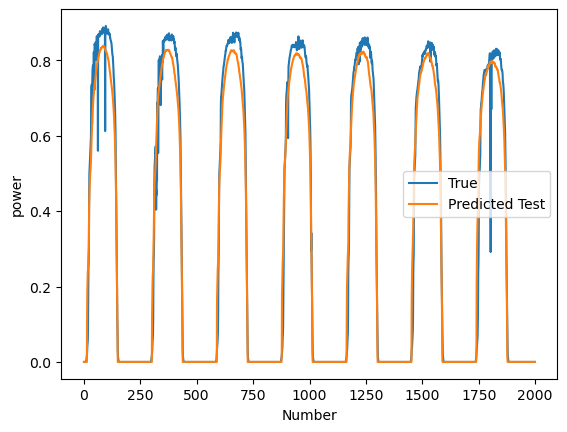

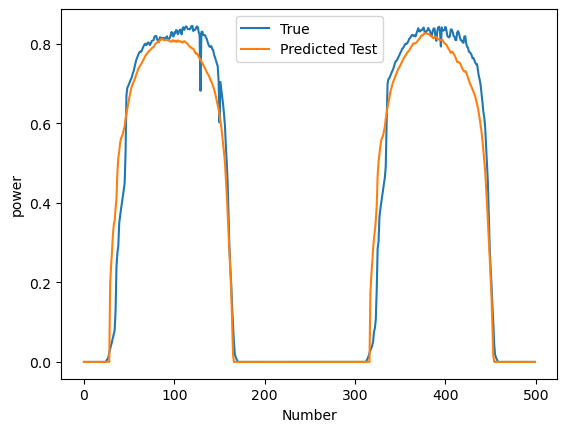

In [8]:
plt.plot(True_test[0:2000], label='True')
plt.plot(predicted_LSTM_Att[0:2000], label='Predicted Test')
plt.xlabel('Number')
plt.ylabel('power')
plt.legend()
plt.show()
plt.plot(True_test[2000:2500], label='True')
plt.plot(predicted_LSTM_Att[2000:2500], label='Predicted Test')
plt.xlabel('Number')
plt.ylabel('power')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# 计算MAPE、RMSE和R2
mape = mean_absolute_percentage_error(True_test, predicted_LSTM_Att)
rmse = mean_squared_error(True_test, predicted_LSTM_Att, squared=False)
r2 = r2_score(True_test, predicted_LSTM_Att)

print(f'MAPE: {mape}, RMSE: {rmse}, R2: {r2}')
# 保存模型参数，在test数据集上直接调用就行
model_lstm_attention.save('GRU_Attention')

MAPE: 507279808672.28094, RMSE: 0.06929838407286015, R2: 0.9624071705140905
INFO:tensorflow:Assets written to: GRU_Attention\assets


INFO:tensorflow:Assets written to: GRU_Attention\assets


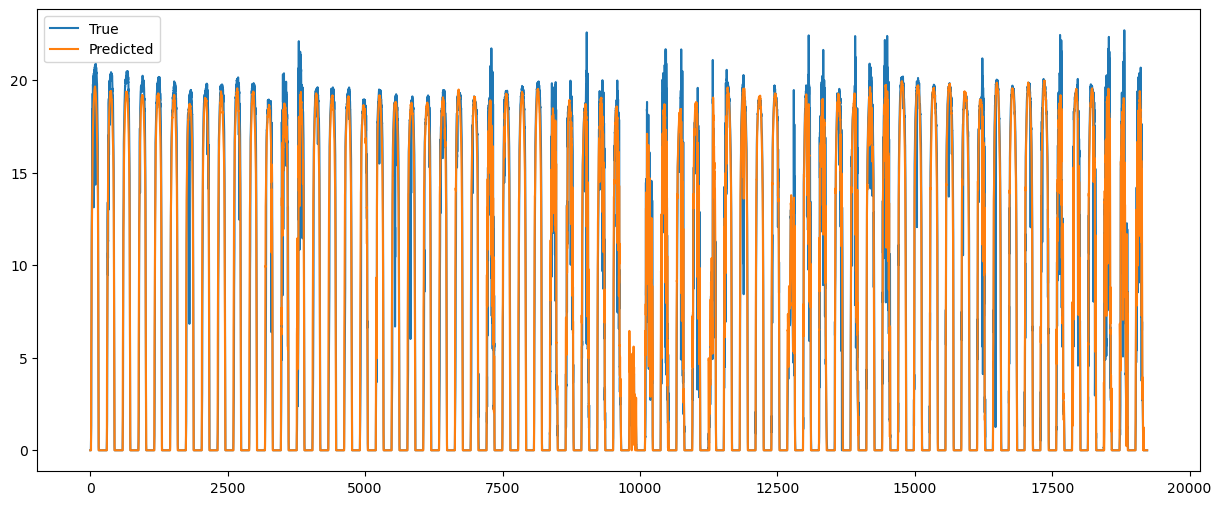

In [10]:
# 最后一步，反归一化输出
scaler_traget = MinMaxScaler(feature_range=(0, 1))
scaler_traget.fit_transform(np.array(df['Active_Power']).reshape(-1, 1))
# 反归一化
predictions = scaler_traget.inverse_transform(predicted_LSTM_Att.reshape(-1, 1))
y_test = scaler_traget.inverse_transform(y_test.reshape(-1, 1))

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.savefig('../Figure/Train_Result_Gru-Attention.jpg', dpi=300)
plt.show()

# 现在有几个任务：
## 1.调参来提高模型精度
## 2.处理测试集的数据，主要是修复一下异常值然后开始训练
## 3.换不同模型，或者尝试机器学习
做一个重要排序,应该是2-1-3

In [11]:
# new_model = tf.keras.models.load_model('GRU_Attention')
